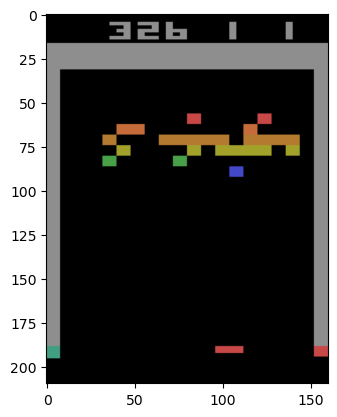

In [3]:
import gymnasium as gym
import cv2
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

import torch
import torch.nn as nn

class Dueling_Network(nn.Module):
    def __init__(self, n_frame, n_actions):
        super(Dueling_Network, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(n_frame,32,8,4)
        self.conv2 = nn.Conv2d(32,64,4,2)
        self.conv3 = nn.Conv2d(64,64,3,1)
        self.act_fc = nn.Linear(3136 , 512)
        self.act_fc2 = nn.Linear(512, n_actions)
        self.value_fc = nn.Linear(3136 , 512)
        self.value_fc2 = nn.Linear(512, 1)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        torch.nn.init.kaiming_normal_(self.act_fc.weight)
        torch.nn.init.kaiming_normal_(self.act_fc2.weight)
        torch.nn.init.kaiming_normal_(self.value_fc.weight)
        torch.nn.init.kaiming_normal_(self.value_fc2.weight)      
        self.flatten = nn.Flatten()  

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        x_act = self.relu(self.act_fc(x))
        x_act = self.act_fc2(x_act)
        x_val = self.relu(self.value_fc(x))
        x_val = self.value_fc2(x_val)
        x_act_ave = torch.mean(x_act, dim=1, keepdim=True)
        q = x_val + x_act - x_act_ave
        return q

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
resize = 84
n_frame = 6
n_actions = env.action_space.n

state, info = env.reset()
old_life = info['lives']
n_observations = len(state.flatten())
target_net = Dueling_Network(n_frame, n_actions).to(device)
target_net.load_state_dict(torch.load('300000.pth'))
target_net.eval()

state_frames = torch.zeros((1, n_frame, resize, resize), dtype=torch.float32, device=device)
observation, reward, terminated, truncated, info = env.step(1)
observation_frame = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)/255.
observation_frame = cv2.resize(src=observation_frame[32:,8:152], dsize=(resize, resize))
state_frames[:,0,:,:] = torch.tensor(observation_frame, dtype=torch.float32, device=device).unsqueeze(0)


while True:
    action = target_net(state_frames).argmax().view(1, 1)

    if old_life > info['lives']:
        old_life = info['lives']
        action = 1
    observation, reward, terminated, truncated, info = env.step(action)
    plt.imshow(observation)
    display.display(plt.gcf())
    display.clear_output(wait=True)

    observation_frame = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)/255.
    observation_frame = cv2.resize(src=observation_frame[32:,8:152], dsize=(resize, resize))
    observation_frame = torch.tensor(observation_frame, dtype=torch.float32, device=device).unsqueeze(0)

    state_frames = torch.roll(input=state_frames, shifts=1, dims=1)
    state_frames[:,0,:,:] = observation_frame
    if terminated or truncated:
        break